In [3]:
import geopandas as gpd
import osmnx as ox
import networkx as nx

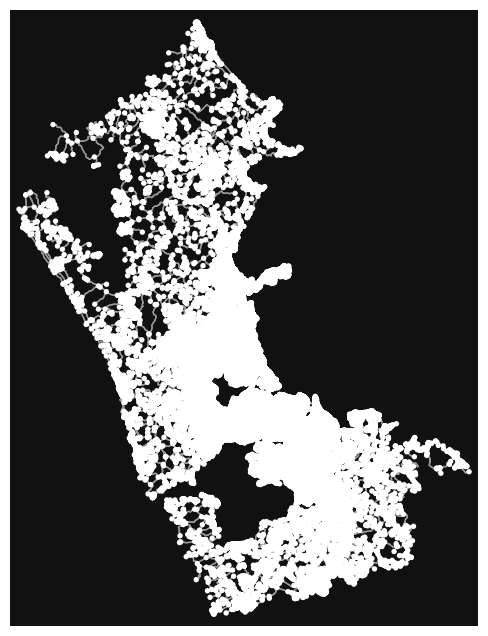

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [4]:
G = ox.graph_from_place("Auckland, New Zealand")
ox.plot_graph(G)

In [5]:
ox.basic_stats(G)

{'n': 219854,
 'm': 571662,
 'k_avg': 5.200378432960055,
 'edge_length_total': 40753281.95300052,
 'edge_length_avg': 71.28912181149092,
 'streets_per_node_avg': 2.7618965313344312,
 'streets_per_node_counts': {0: 0,
  1: 47605,
  2: 1684,
  3: 126965,
  4: 42853,
  5: 617,
  6: 87,
  7: 21,
  8: 19,
  9: 2,
  10: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.21653006085856977,
  2: 0.007659628662657946,
  3: 0.5774968842959418,
  4: 0.1949157167938723,
  5: 0.0028064078888717058,
  6: 0.00039571715775014326,
  7: 9.551793462934493e-05,
  8: 8.642098847416922e-05,
  9: 9.096946155175708e-06,
  10: 4.548473077587854e-06},
 'intersection_count': 172249,
 'street_length_total': 21283836.32199904,
 'street_segment_count': 304175,
 'street_length_avg': 69.97233935069956,
 'circuity_avg': 1.112977038309792,
 'self_loop_proportion': 0.00497082271718583}

In [4]:
print("node count:", len(G.nodes()))
print("edge count:", len(G.edges()))

node count: 219854
edge count: 571662


In [5]:
# find nearest node
near_node = ox.distance.nearest_nodes(G,[174.6153994630523],[-36.88436663546332])[0]
near_node

11232624390

In [6]:
# find node by ID and show its properties
G.nodes.get(near_node)

{'y': -36.884444, 'x': 174.6152816, 'street_count': 3}

In [7]:
# find its neighbouring nodes
list(G.neighbors(near_node))

[11232624396, 11232624397, 11232715956]

In [8]:
import json

# show edge attributes
for edge in G.out_edges(near_node, data=True):
    print("\n=== Edge ====")
    print("Source and target node ID:", edge[:2])
    edge_attributes = edge[2]
    # remove geometry object from output
    edge_attributes_wo_geometry = {i:edge_attributes[i] for i in edge_attributes if i!='geometry'}
    print("Edge attributes:", json.dumps(edge_attributes_wo_geometry, indent=4))


=== Edge ====
Source and target node ID: (11232624390, 11232624396)
Edge attributes: {
    "osmid": 1212390051,
    "highway": "footway",
    "oneway": false,
    "reversed": false,
    "length": 6.295
}

=== Edge ====
Source and target node ID: (11232624390, 11232624397)
Edge attributes: {
    "osmid": 1212390050,
    "highway": "footway",
    "oneway": false,
    "reversed": false,
    "length": 111.816
}

=== Edge ====
Source and target node ID: (11232624390, 11232715956)
Edge attributes: {
    "osmid": 1212400716,
    "highway": "footway",
    "oneway": false,
    "reversed": true,
    "length": 70.719
}


In [9]:
# impute edge (driving) speeds and calculate edge traversal times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [10]:
edges, nodes = ox.graph_to_gdfs(G)

In [11]:
#creating a geocoding function to convert string address to coordinates

def geocoding(address, crs=4326):
    try:
        geocode= gpd.tools.geocode(address, provider='nominatim', user_agent='auckland_geocode', timeout=10).to_crs(crs)
        
        if not geocode.empty:
            
            return (geocode.iloc[0].geometry.y, geocode.iloc[0].geometry.x)
        else:
            raise ValueError("Geocoding returned an empty result.")
            
    except Exception as e:
        print(f"Error geocoding address '{address}': {e}")
        return None    
        

In [12]:
origin_node= geocoding('Alderman Drive, Henderson, Auckland 0612, New Zealand')
destination_node = geocoding('21 Elliott Street, Auckland CBD, Auckland 1010, New Zealand')

In [13]:
origin_node[1]

174.6329894

In [14]:
# Finding out the nearest node to the origin and destinations

origin_near_node= ox.distance.nearest_nodes(G, origin_node[1],origin_node[0])
destination_near_node = ox.distance.nearest_nodes(G, destination_node[1],destination_node[0])

In [15]:
# Now calculatinf the shortest path between OD nodes

route = nx.shortest_path(G, origin_near_node, destination_near_node, weight='travel_time')

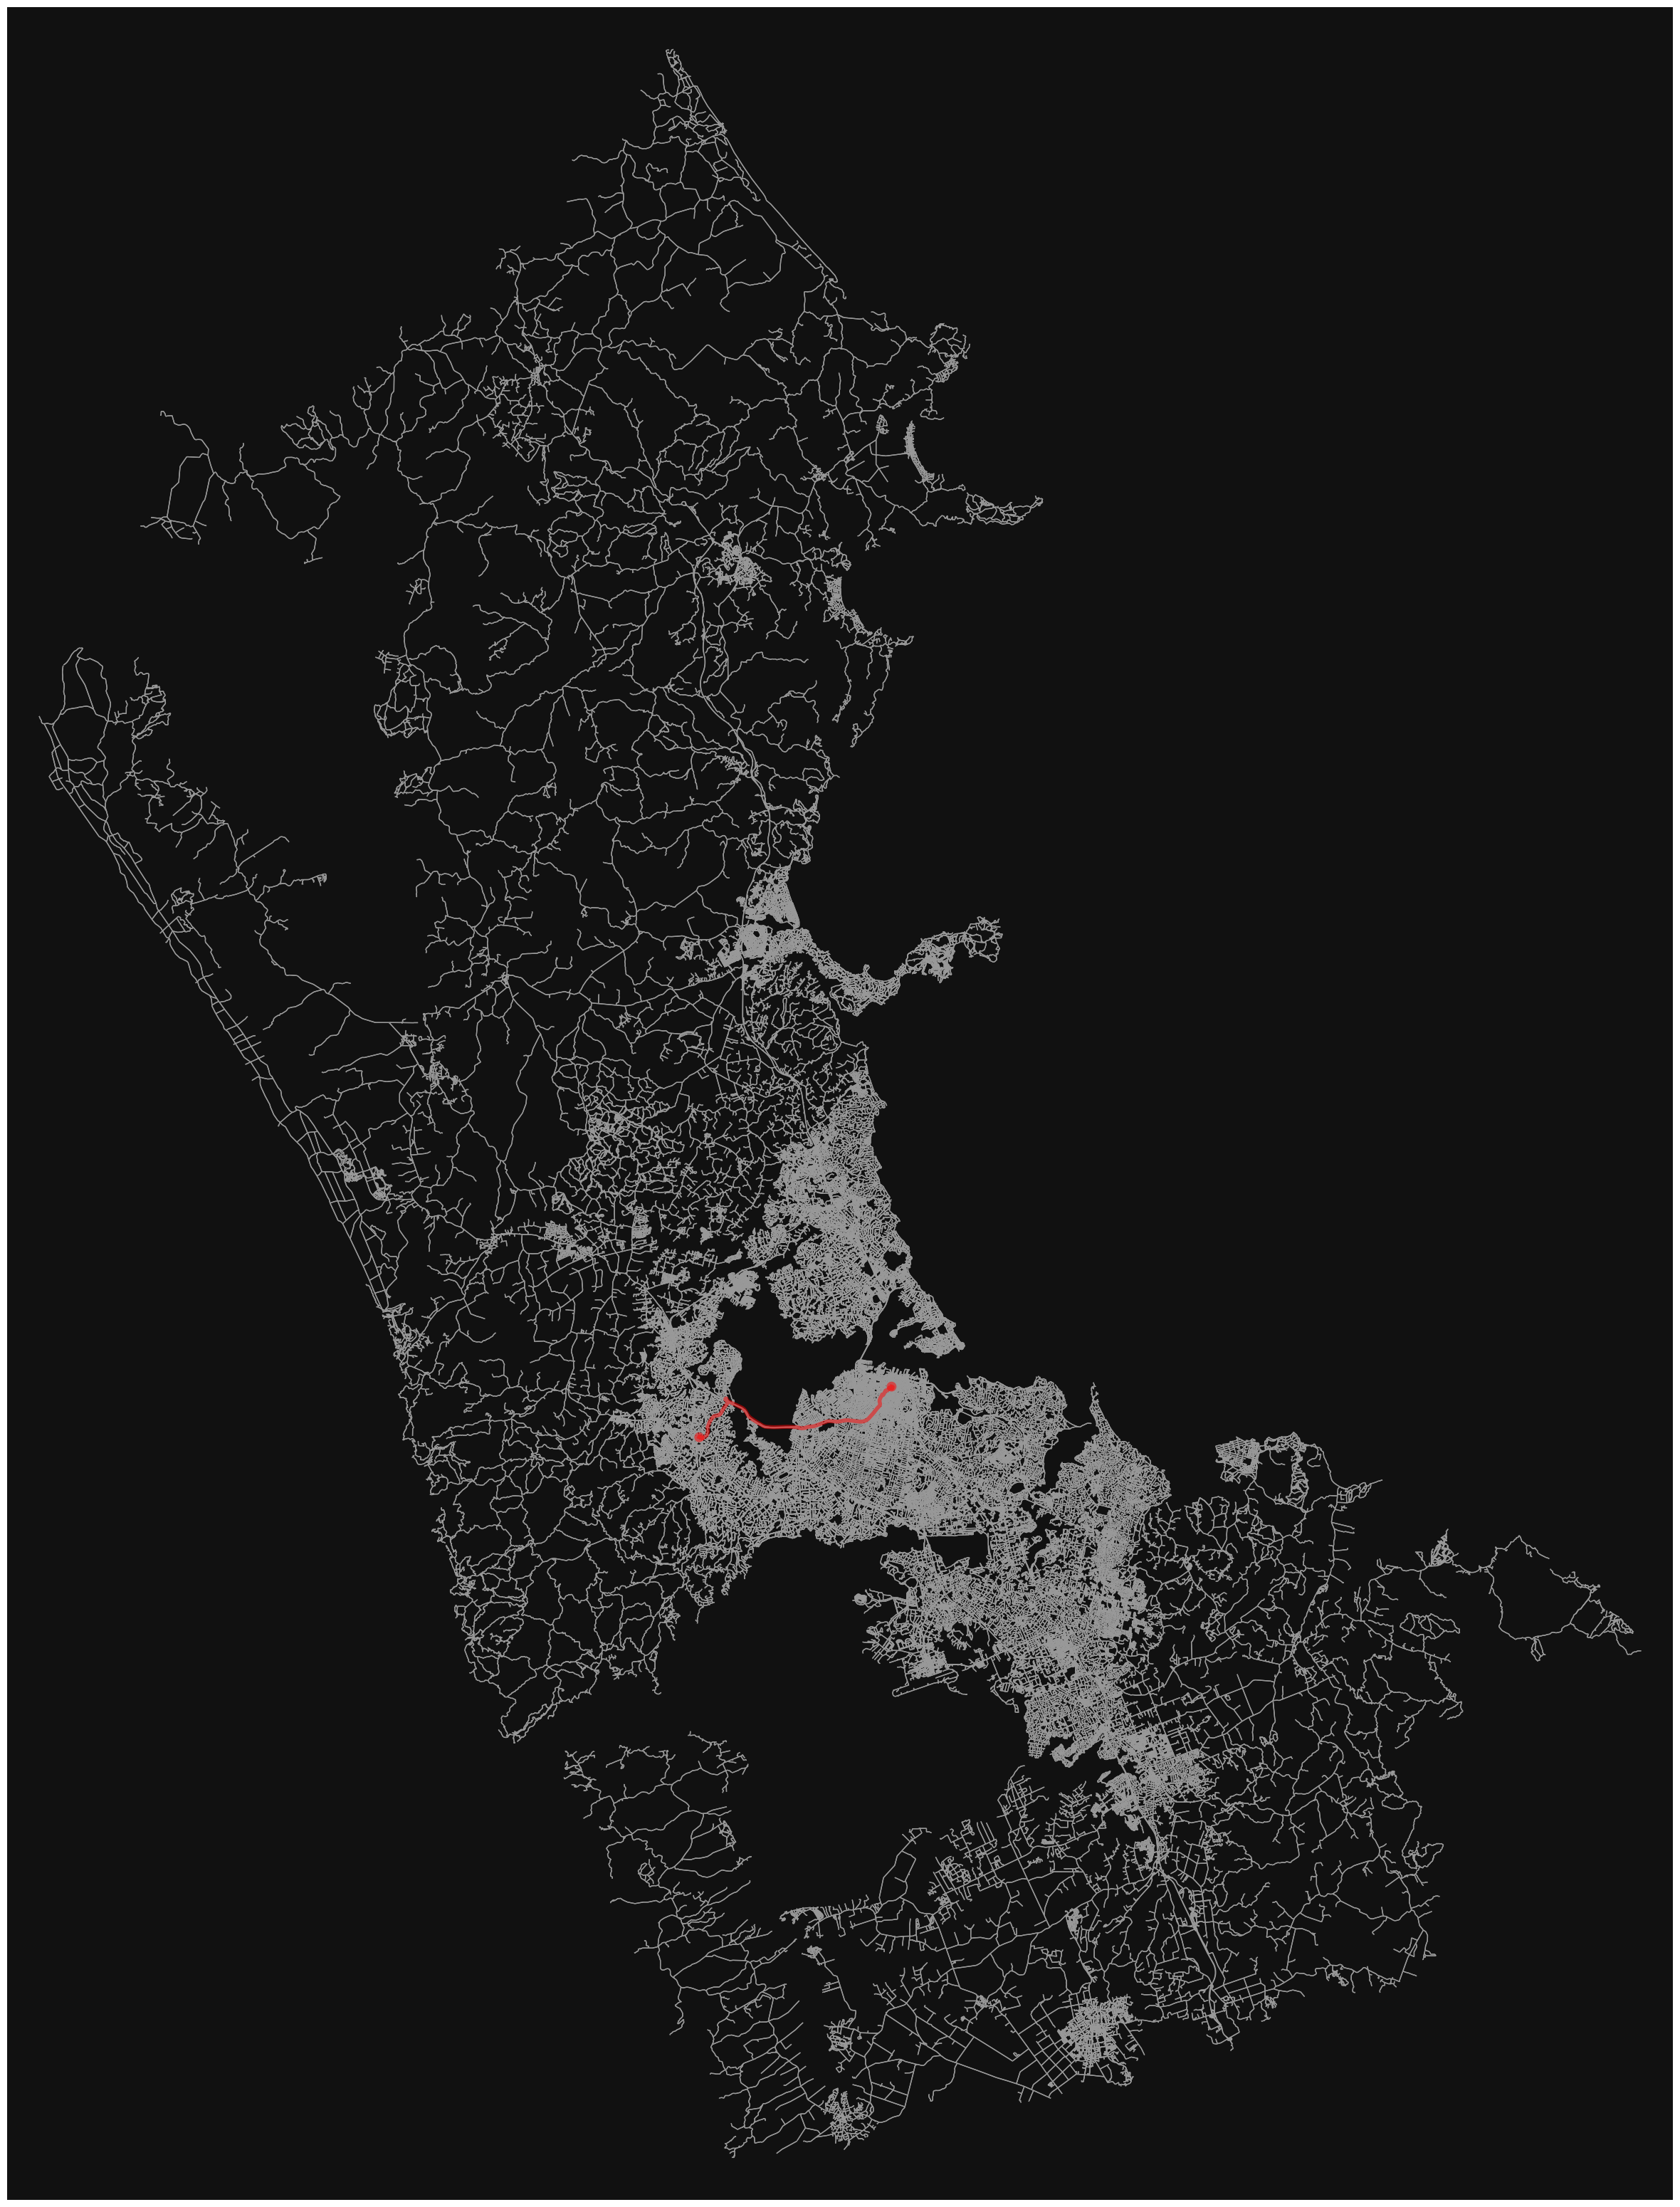

In [16]:
# Plotting the route

fig, ax = ox.plot_graph_route(G, route, node_size=0, figsize=(40,40))

In [17]:
#Calculating the total distance using iteration (Note: This method is considered to be more accurate as comapred to the below one)
# Initialize total distance variable

total_distance = 0

# Iterate over the route nodes
for i in range(len(route) - 1):
    u = route[i]
    v = route[i + 1]
    
    # Get edge length between nodes u and v
    edge_data = G.get_edge_data(u, v)
    if edge_data is not None and 'length' in edge_data[0]:
        edge_length = edge_data[0]['length']
        total_distance += edge_length

print(f"Total distance of the route: {total_distance} meters")


Total distance of the route: 15728.644000000004 meters


In [18]:
# Calculate the total distance of the shortest path
total_distance = nx.shortest_path_length(G, origin_near_node, destination_near_node, weight='length')

print(f"Total distance of the route: {total_distance} meters")


Total distance of the route: 14838.526 meters


In [19]:
# Another way for calculating routes lengths and travel times:

edge_lengths = ox.utils_graph.get_route_edge_attributes(
    G, route, 'length') 
total_route_length = sum(edge_lengths)
print("Total route length in km:", total_route_length/1000)

edge_travel_time = ox.utils_graph.get_route_edge_attributes(
    G, route, 'travel_time') 
route_travel_time = sum(edge_travel_time)
print("Travel time in minutes:", route_travel_time/60)

Total route length in km: 15.728644000000005
Travel time in minutes: 12.896666666666668


C:\Users\INAK05404\AppData\Local\Temp\ipykernel_26980\3202360433.py:3: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  edge_lengths = ox.utils_graph.get_route_edge_attributes(
C:\Users\INAK05404\AppData\Local\Temp\ipykernel_26980\3202360433.py:8: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  edge_travel_time = ox.utils_graph.get_route_edge_attributes(


In [20]:
ox.utils_graph.get_route_edge_attributes(G,route)

C:\Users\INAK05404\AppData\Local\Temp\ipykernel_26980\3204785803.py:1: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.utils_graph.get_route_edge_attributes(G,route)


[{'osmid': 1185921267,
  'highway': 'footway',
  'oneway': False,
  'reversed': False,
  'length': 6.055,
  'speed_kph': 46.5,
  'travel_time': 0.5},
 {'osmid': 1189025003,
  'highway': 'footway',
  'oneway': False,
  'reversed': False,
  'length': 27.479,
  'geometry': <LINESTRING (174.633 -36.877, 174.633 -36.877, 174.633 -36.877)>,
  'speed_kph': 46.5,
  'travel_time': 2.1},
 {'osmid': 1189025002,
  'highway': 'footway',
  'oneway': False,
  'reversed': False,
  'length': 48.286,
  'geometry': <LINESTRING (174.633 -36.877, 174.633 -36.877, 174.633 -36.877, 174.633 -36....>,
  'speed_kph': 46.5,
  'travel_time': 3.7},
 {'osmid': 1185921266,
  'highway': 'footway',
  'oneway': False,
  'reversed': True,
  'length': 7.833,
  'speed_kph': 46.5,
  'travel_time': 0.6},
 {'osmid': [666658243, 30910387, 390412003],
  'lanes': ['3', '2'],
  'ref': '13; 19A',
  'name': 'Alderman Drive',
  'highway': 'secondary',
  'maxspeed': '50',
  'oneway': False,
  'reversed': False,
  'length': 69.44,
  

In [21]:
route_gdf= ox.routing.route_to_gdf(G,route,weight='length')
route_gdf.head()

,,,osmid,oneway,name,highway,reversed,length,geometry,speed_kph,travel_time,lanes,ref,maxspeed,bridge,service,tunnel,junction
u,v,key,,,,,,,,,,,,,,,,
1403192828,1403192826,0,1185921267,False,NaN,footway,False,6.055,"LINESTRING (174.63302 -36.87733, 174.63308 -36...",46.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1403192826,11040668331,0,1189025003,False,NaN,footway,False,27.479,"LINESTRING (174.63308 -36.87736, 174.63309 -36...",46.5,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11040668331,11015578545,0,1189025002,False,NaN,footway,False,48.286,"LINESTRING (174.63321 -36.87713, 174.63327 -36...",46.5,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11015578545,2972088505,0,1185921266,False,NaN,footway,True,7.833,"LINESTRING (174.63369 -36.87704, 174.63374 -36...",46.5,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2972088505,412086687,0,"[666658243, 30910387, 390412003]",False,Alderman Drive,secondary,False,69.440,"LINESTRING (174.63374 -36.87698, 174.63383 -36...",50.0,5.0,"[3, 2]",13; 19A,50,yes,NaN,NaN,NaN


In [22]:
Office_Auck = gpd.read_file('C:/Aditya/WSP_Office_addresses/auckland_offices2.shp')
Office_Auck

,Office_No,Office_Uni,Address_Li,Suburb,City,Postcode,Country,Full_Addre,Office_Typ,Bus_Route_,Check,Address_Va,address,Office_No_,Full_Add_1,LAT,LONG,geometry
0,O-3,None,3/100 Beaumont Street,Auckland CBD,Auckland,1010,New Zealand,"3/100 Beaumont Street, Auckland CBD, Auckland,...",Office,None,TRUE,None,"Beaumont Street, Victoria Quarter, Wynyard Qua...",O-3,"3/100 Beaumont Street, Auckland CBD, Auckland,...",-36.845195,174.752932,POINT (1756291.511 5920866.522)
1,O-4,Unit A,7 Ride Way,Rosedale,Auckland,632,New Zealand,"7 Ride Way, Rosedale, Auckland, 632, New Zealand",Lab,None,TRUE,None,None,O-4,"7 Ride Way, Rosedale, Auckland, 632, New Zealand",-36.751799,174.701879,POINT (1751923.628 5931310.498)
2,O-5,None,Cook Street,None,Auckland,1010,New Zealand,"Cook Street, , Auckland , 1010, New Zealand",Storage Unit,None,TRUE,None,"Cook Street, Victoria Quarter, Freemans Bay, A...",O-5,"Cook Street, , Auckland , 1010, New Zealand",-36.850297,174.755150,POINT (1756478.894 5920296.870)
3,O-6,None,"15 Putney Way, Manukau City Centre",None,Auckland,2104,New Zealand,"15 Putney Way, Manukau City Centre, , Auckland...",Office,None,TRUE,None,None,O-6,"15 Putney Way, Manukau City Centre, , Auckland...",-36.992903,174.878959,POINT (1767206.294 5904264.827)


In [23]:
Emp_Auck = gpd.read_file('C:/Aditya/WSP_Office_addresses/auckland_employees.shp')
q = Emp_Auck.query("Employee"== 'R-528')

ValueError: expr must be a string to be evaluated, <class 'bool'> given

In [24]:
Office_Auck.iloc[1].geometry.y

5931310.4984

In [25]:
origin_node= ["1751923.6283999998","5931310.4984"]
destnation_node=[]

In [26]:
origin_node

['1751923.6283999998', '5931310.4984']

In [27]:
office_tupl = []

for idx, row in Office_Auck.iterrows():
    X_office = row.geometry.x
    Y_office = row.geometry.y
    office_tupl.append((Y_office, X_office))

In [28]:
office_tupl

[(5920866.5218, 1756291.5113000004),
 (5931310.4984, 1751923.6283999998),
 (5920296.8699, 1756478.8935000002),
 (5904264.8275, 1767206.2944)]

In [29]:
#Unpacking the tuple to generate x an y coordinate pairs
Y_coords, X_coords = zip(*office_tupl)

In [30]:
X_coords

(1756291.5113000004, 1751923.6283999998, 1756478.8935000002, 1767206.2944)

In [2]:
office_near_node = ox.distance.nearest_nodes(G,Y_coords,X_coords)

NameError: name 'G' is not defined

In [33]:
G.nodes.get(office_near_node[1])

{'y': -36.3191518, 'x': 174.2659011, 'street_count': 1}

In [34]:
office_near_node

[2199212368, 8456236959, 8456236959, 3659583044]

In [35]:
emp_tupl =[]

for idx,row in Emp_Auck.iterrows():
    X_emp = row.geometry.x
    Y_emp = row.geometry.y
    emp_tupl.append((Y_emp,X_emp))

In [36]:
#Unpacking the tuple to generate x an y coordinate pairs
Y_coords1,X_coords1 = zip(*emp_tupl)

In [37]:
Emp_near_node = ox.distance.nearest_nodes(G,Y_coords1,X_coords1)

In [38]:
Emp_near_node

[2199212368,
 8456236959,
 4407330662,
 8444753337,
 8444753337,
 4407330662,
 11133074198,
 11132258890,
 3659583044,
 8444753337,
 6218340282,
 11132258890,
 11132258890,
 1820953576,
 11132258890,
 8444753329,
 3659583044,
 11133074198,
 3659583044,
 3659583044,
 8456236959,
 852578472,
 1820953576,
 11132258890,
 1820953576,
 11132258890,
 8456236959,
 11132258890,
 8119848129,
 8444753337,
 11132258890,
 852578472,
 8444753337,
 8444753337,
 852578472,
 3659583044,
 6218340282,
 4822640792,
 8456236959,
 8444753329,
 2199212368,
 3659583044,
 8444753337,
 11132258890,
 3659583044,
 3659583044,
 8444753337,
 3659583044,
 8444753337,
 3659583044,
 11132258890,
 8444753337,
 11132258890,
 3659583044,
 3659583044,
 11133074198,
 8444753329,
 8444753337,
 11133074198,
 8456236959,
 11132258890,
 11132258890,
 11132258890,
 4338019973,
 852578472,
 11132258890,
 2199212368,
 11132258890,
 8456236959,
 8444753337,
 8444753329,
 11132258890,
 4822640792,
 11132258890,
 11133074198,
 84562

In [39]:
# Calculating the Shortest path Route

for i in office_near_node,Emp_near_node:
    route = nx.shortest_path(G, office_near_node[i], Emp_near_node[i], weight='travel_time')
    



TypeError: list indices must be integers or slices, not list

In [40]:
import networkx as nx
import osmnx as ox

# Assuming office_near_node and Emp_near_node are lists of node IDs
for office_node in office_near_node:
    for emp_node in Emp_near_node:
        route = nx.shortest_path(G, source=office_node, target=emp_node, weight='travel_time')
        # Process the route as needed
        print(f"Shortest path from office node {office_node} to employee node {emp_node}:")
        print(route)
        print()



Shortest path from office node 2199212368 to employee node 2199212368:
[2199212368]

Shortest path from office node 2199212368 to employee node 8456236959:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 279053127,

Shortest path from office node 2199212368 to employee node 3659583044:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 6218340282:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 1820953576:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 3659583044:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 3659583044:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 1820953576:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 8119848129:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 279052483, 279053735, 279053477, 3294315571, 3294315578, 2321336273, 8929669258, 8929669173, 745322969, 745347260, 745322744, 8929668797, 745322626, 6065674461, 4812941989, 248846872, 3130963709, 7588583694, 633049608, 7588

Shortest path from office node 2199212368 to employee node 852578472:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 2790

Shortest path from office node 2199212368 to employee node 852578472:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 2790

Shortest path from office node 2199212368 to employee node 6218340282:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 8444753329:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 8444753337:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 3659583044:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 3659583044:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 3659583044:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 3659583044:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 8444753329:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 11132258890:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 279053127, 279053644, 279053843, 7310808883, 7310808884, 279053841, 279053322, 279052662, 7624

Shortest path from office node 2199212368 to employee node 8444753337:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 4822640792:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 11132258890:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 279053127, 279053644, 279053843, 7310808883, 7310808884, 279053841, 279053322, 279052662, 7624

Shortest path from office node 2199212368 to employee node 8444753329:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

Shortest path from office node 2199212368 to employee node 3659583044:
[2199212368, 2199212384, 936116193, 936116145, 936116139, 936116158, 5259661141, 936116163, 820382901, 9078406091, 11959502764, 820382569, 820383092, 820382799, 820382738, 820382701, 2476580537, 1028972619, 1028980429, 2476580584, 2476580612, 2476580615, 2476580621, 2476580646, 2476580648, 2476580659, 2476580696, 820382555, 2476580759, 2476580785, 2476580778, 1706598691, 2476594711, 11968319753, 4791618571, 820382572, 820382963, 820383003, 703152565, 703152734, 1276817011, 1028984809, 8222776353, 703152711, 4792958717, 279051895, 279051937, 4792958668, 703150203, 703150206, 10591353522, 279054175, 703150205, 1276822079, 745322697, 279054002, 279054177, 745322469, 4921972933, 279052431, 279053739, 8358832198, 3388910265, 3388910290, 1536387537, 7624776135, 279053619, 745322576, 7624776088, 7624760247, 279052610, 279053614, 7609041570, 7609041568, 279053317, 279052613, 279052597, 279053377, 2310778738, 2310778758, 279

NetworkXNoPath: No path between 2199212368 and 9971763462.

In [41]:
route

[2199212368,
 2199212384,
 936116193,
 936116145,
 936116139,
 936116158,
 5259661141,
 936116163,
 820382901,
 9078406091,
 11959502764,
 820382569,
 820383092,
 820382799,
 820382738,
 820382701,
 2476580537,
 1028972619,
 1028980429,
 2476580584,
 2476580612,
 2476580615,
 2476580621,
 2476580646,
 2476580648,
 2476580659,
 2476580696,
 820382555,
 2476580759,
 2476580785,
 2476580778,
 1706598691,
 2476594711,
 11968319753,
 4791618571,
 820382572,
 820382963,
 820383003,
 703152565,
 703152734,
 1276817011,
 1028984809,
 8222776353,
 703152711,
 4792958717,
 279051895,
 279051937,
 4792958668,
 703150203,
 703150206,
 10591353522,
 279054175,
 703150205,
 1276822079,
 745322697,
 279054002,
 279054177,
 745322469,
 4921972933,
 279052431,
 279053739,
 8358832198,
 3388910265,
 3388910290,
 1536387537,
 7624776135,
 279053619,
 745322576,
 7624776088,
 7624760247,
 279052610,
 279053614,
 7609041570,
 7609041568,
 279053317,
 279052613,
 279052597,
 279053377,
 2310778738,
 2310778

In [42]:
import networkx as nx
import osmnx as ox

# Assuming office_near_node and Emp_near_node are lists of node IDs
paths = []

for office_node in office_near_node:
    for emp_node in Emp_near_node:
        route = nx.shortest_path(G, source=office_node, target=emp_node, weight='travel_time')
        paths.append((office_node, emp_node, route))

# Process and print the paths as needed
for office_node, emp_node, route in paths:
    print(f"Shortest path from office node {office_node} to employee node {emp_node}:")
    print(route)
    print()


NetworkXNoPath: No path between 2199212368 and 9971763462.

In [2]:
import networkx as nx
import osmnx as ox

# Assuming office_near_node and Emp_near_node are lists of node IDs
paths = {}

route_number = 1
for office_node in office_near_node:
    for emp_node in Emp_near_node:
        try:
            route = nx.shortest_path(G, source=office_node, target=emp_node, weight='travel_time')
            paths[route_number] = (office_node, emp_node, route)
        except nx.NetworkXNoPath:
            paths[route_number] = (office_node, emp_node, "No path available")
        route_number += 1

def get_route(route_number):
    if route_number in paths:
        office_node, emp_node, route = paths[route_number]
        if route == "No path available":
            print(f"No path between office node {office_node} and employee node {emp_node}.")
            return None
        else:
            print(f"Shortest path from office node {office_node} to employee node {emp_node}:")
            print(route)
            print()
            return route
    else:
        print(f"Route number {route_number} does not exist.")
        return None


NameError: name 'office_near_node' is not defined

In [1]:
get_route(2)

NameError: name 'get_route' is not defined

In [ ]:
get_route(2)

In [ ]:
route2= get_route(25)

In [ ]:
fig, ax = ox.plot_graph_route(G, route2, node_size=0, figsize=(40,40))

In [ ]:
route3= get_route(36)

In [ ]:
fig, ax = ox.plot_graph_route(G, route3, node_size=0, figsize=(30,30))

In [ ]:
PLACE_NAME = "Auckland, New Zealand"
area = ox.geocode_to_gdf(PLACE_NAME)
area.plot()


In [ ]:
edges, nodess = ox.graph_to_gdfs(G)

In [ ]:
import matplotlib
figure, ax = matplotlib.pyplot.subplots(figsize=(15,10))

# Plot the footprint
area.plot(ax=ax, facecolor="black")

# Plot street ‘edges’
edges.plot(ax=ax, linewidth=1, edgecolor="grey")

# Plot Offices
Office_Auck.plot(ax=ax, color="yellow", alpha=0.7, markersize=10)

In [ ]:
fig,ax=ox.plot.plot_footprints(Office_Auck, figsize=(8, 8), color='orange')

In [ ]:
Emp_Auck.plot()

In [ ]:
route2= ox.routing.shortest_path(G,office_near_node,Emp_near_node, weight='length',cpus=1)